### Random Sampling Validation and Dataset Creation!

<br> 

##### In this notebook we aim to
- Count proportion of imbalanced features from each year (global truth)
- Speedily and randomly select from sql database
- Count proportion of imbalanced features from each year and each random sample (sampled truth)
- Compare global truth and sampled truth and deem acceptibility

<br>

#### Steps to getting there:
- import yearly database tables
    - get count of imbalanced features
    - calculate the ratio
    - store results
- import random subsample of yearly database
    - repeat above
- compare the global and local proportions graphically
- after sampling is acceptable then save the csv

### Import relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from matplotlib.ticker import PercentFormatter
import numpy as np

### Creating connection to local sqlite database

In [2]:
# !pip install ipython-sql
%load_ext sql
%sql sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db

### Comparing the global 'truth' and local 'representation' of imbalanced features

#### Global - Proportion of rides taken from each station

In [12]:
%%time
# sql query for total rides from station
result = %sql SELECT start_station_name, SUM (counter) from yr_2019 GROUP BY start_station_name;
# convert into pandas df
df_station_global = result.DataFrame()
# sort descending
df_station_global.sort_values(by=['SUM (counter)'], inplace=True, ascending=False)
# rename column
df_station_global.rename(columns={"SUM (counter)": "num_rides"}, inplace=True)
# getting proportion of rides from each station
df_station_global['percent_rides'] = 100 * (df_station_global['num_rides'] / df_station_global['num_rides'].sum())
# displaying results
df_station_global.head(2)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
CPU times: user 15.2 s, sys: 4.41 s, total: 19.6 s
Wall time: 29.9 s


,start_station_name,num_rides,percent_rides
747,Pershing Square North,156575,0.747138
380,E 17 St & Broadway,121781,0.581109


#### Local - Proportion of rides taken from each station

In [13]:
%%time
# sql query to get 5% random sample
result = %sql SELECT * FROM yr_2019 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
# convert into pandas df
df_station_local = result.DataFrame()
# group by station name and sum occurences
df_station_local = df_station_local.groupby(['start_station_name'])['counter'].sum().reset_index()
# sort descending
df_station_local.sort_values(by=['counter'], inplace=True, ascending=False)
# rename column
df_station_local.rename(columns={"counter": "num_rides"}, inplace=True)
# getting proportion of rides from each station
df_station_local['percent_rides'] = 100 * (df_station_local['num_rides'] / df_station_local['num_rides'].sum())
# displaying results
df_station_local.head(2)

# Size of subsampled csv is 50kb
# df_station_local.to_csv('size.csv') 

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
CPU times: user 11.9 s, sys: 2.76 s, total: 14.7 s
Wall time: 21 s


,start_station_name,num_rides,percent_rides
744,Pershing Square North,7644,0.729488
378,E 17 St & Broadway,6196,0.591301


#### Function to perform sample validation (i.e. is our sample representative?)

In [14]:
def sample_validation(df_station_global = df_station_global,
                      df_station_local = df_station_local,
                      num_samples = 3,
                      ratio_grab = 0.05):
    
    # Prepare data FOR the LOOP
    df_station_global_for_loop = df_station_global.drop(['num_rides'], axis=1).rename(columns={"percent_rides": "percent_global_rides"}).set_index('start_station_name')
    
    # Perform first concatenation
    # sql query to get 5% random sample
    result = %sql SELECT * FROM yr_2019 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < $ratio_grab;
    # convert into pandas df
    df_station_local = result.DataFrame()
    # group by station name and sum occurences
    df_station_local = df_station_local.groupby(['start_station_name'])['counter'].sum().reset_index()
    # sort descending
    df_station_local.sort_values(by=['counter'], inplace=True, ascending=False)
    # rename column
    df_station_local.rename(columns={"counter": "num_rides"}, inplace=True)
    # getting proportion of rides from each station
    df_station_local['percent_rides'] = 100 * (df_station_local['num_rides'] / df_station_local['num_rides'].sum())
    # modify df_station_local to prepare for concatenation
    df_station_local_for_loop = df_station_local.drop(['num_rides'], axis=1).set_index('start_station_name')
    
    # Do initial concatenation
    df_station_sampling = pd.concat([df_station_global_for_loop, df_station_local_for_loop], axis=1, sort=False).reindex(df_station_global_for_loop.index)

    # for loop to randomly sample from sql database then save results (proportion of rides taken from a station)
    for x in range(0, (num_samples - 1)):
        print(f'This is iteration {x}')
        # sql query to get 5% random sample
        result = %sql SELECT * FROM yr_2019 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < $ratio_grab;
        # convert into pandas df
        df_station_local_for_loop = result.DataFrame()
        # group by station name and sum occurences
        df_station_local_for_loop = df_station_local_for_loop.groupby(['start_station_name'])['counter'].sum().reset_index()
        # sort descending
        df_station_local_for_loop.sort_values(by=['counter'], inplace=True, ascending=False)
        # rename column
        df_station_local_for_loop.rename(columns={"counter": "num_rides"}, inplace=True)
        # getting proportion of rides from each station
        df_station_local_for_loop['percent_rides'] = 100 * (df_station_local_for_loop['num_rides'] / df_station_local_for_loop['num_rides'].sum())
        # modify df_station_local to prepare for concatenation
        df_station_local_for_loop = df_station_local_for_loop.drop(['num_rides'], axis=1).set_index('start_station_name')
        # concatenate this iteration of df_station_local
        df_station_sampling = pd.concat([df_station_sampling, df_station_local_for_loop], axis=1, sort=False).reindex(df_station_sampling.index)

    return df_station_sampling

In [19]:
# Grab 5% of the data. Do this 40 times. Save Results
sample_five_percent_n_40 = sample_validation(num_samples = 40, ratio_grab = 0.05)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 0
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 1
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 2
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 3
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 4
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 5
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 6
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/d

In [21]:
sample_five_percent_n_40.to_csv('five_percent_sample.csv')

In [22]:
# Grab 0.5% of the data. Do this 40 times. Save Results
sample_one_half_percent_n_40 = sample_validation(num_samples = 40, ratio_grab = 0.005)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 0
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 1
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 2
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 3
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 4
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 5
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 6
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/d

In [26]:
sample_one_half_percent_n_40.to_csv('one_half_percent_sample.csv')

In [23]:
# Grab 15% of the data. Do this 40 times. Save Results
sample_fifteen_percent_n_40 = sample_validation(num_samples = 40, ratio_grab = 0.15)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 0
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 1
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 2
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 3
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 4
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 5
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.
This is iteration 6
 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/d

In [25]:
sample_fifteen_percent_n_40.to_csv('fifteen_percent_sample.csv')

### Conclusions

In [59]:
fifteen = sample_fifteen_percent_n_40.copy()
five = sample_five_percent_n_40.copy()
half = sample_one_half_percent_n_40.copy()

In [60]:
num = pd.DataFrame(half.isna().sum()).iloc[1:][0].mean()
print(f'The average number of missed stations when using 1/2 % sampling is {num}.\n')
num = pd.DataFrame(five.isna().sum()).iloc[1:][0].mean()
print(f'The average number of missed stations when using 5 % sampling is {num}.\n')
num = pd.DataFrame(fifteen.isna().sum()).iloc[1:][0].mean()
print(f'The average number of missed stations when using 15 % sampling is {num}.\n')

The average number of missed stations when using 1/2 % sampling is 46.45.

The average number of missed stations when using 5 % sampling is 9.175.

The average number of missed stations when using 15 % sampling is 2.5.



In [61]:
correct = fifteen.transpose().iloc[:1]
fifteen = fifteen.transpose().iloc[1:]
five = five.transpose().iloc[1:]
half = half.transpose().iloc[1:]

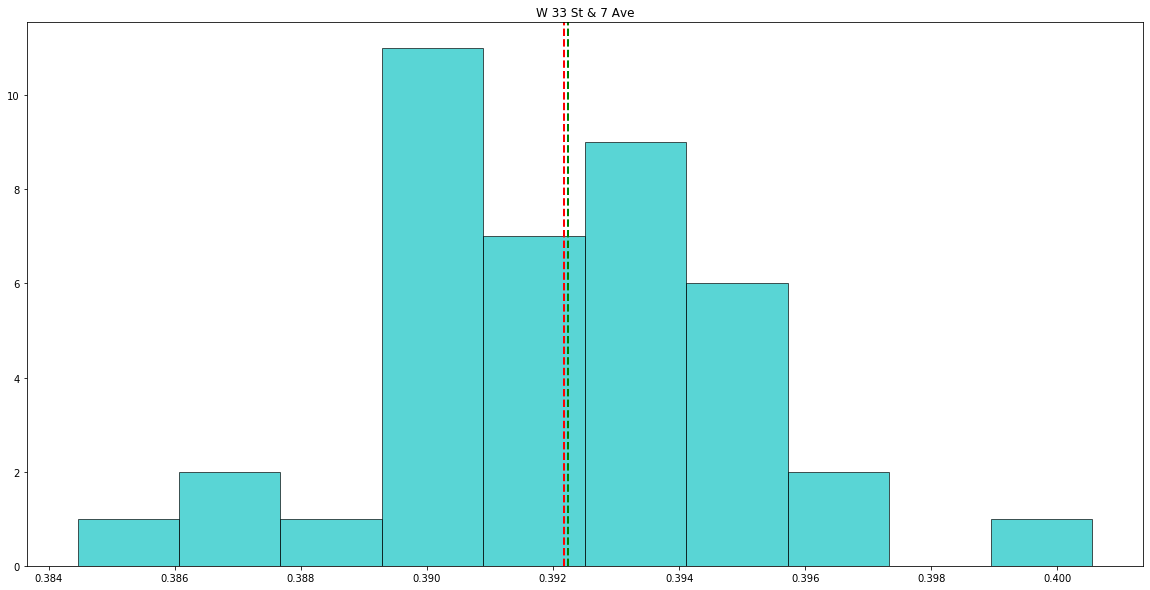

In [172]:
# assign random number so we can look at a variety of station distributions
wild = random.randrange(0, 39)

# get station name associated with this random column
station_name = correct.iloc[:,wild:wild+1].columns.to_list()[0]
# get the true distribution
correct_answer= correct.iloc[:,wild:wild+1].values.flatten()[0]

x = fifteen.copy().iloc[:,wild:wild+1].values.flatten()
plt.figure(figsize=(20,10)) 
result = plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(correct_answer, color='g', linestyle='dashed', linewidth=2)
plt.title(station_name)
plt.show()


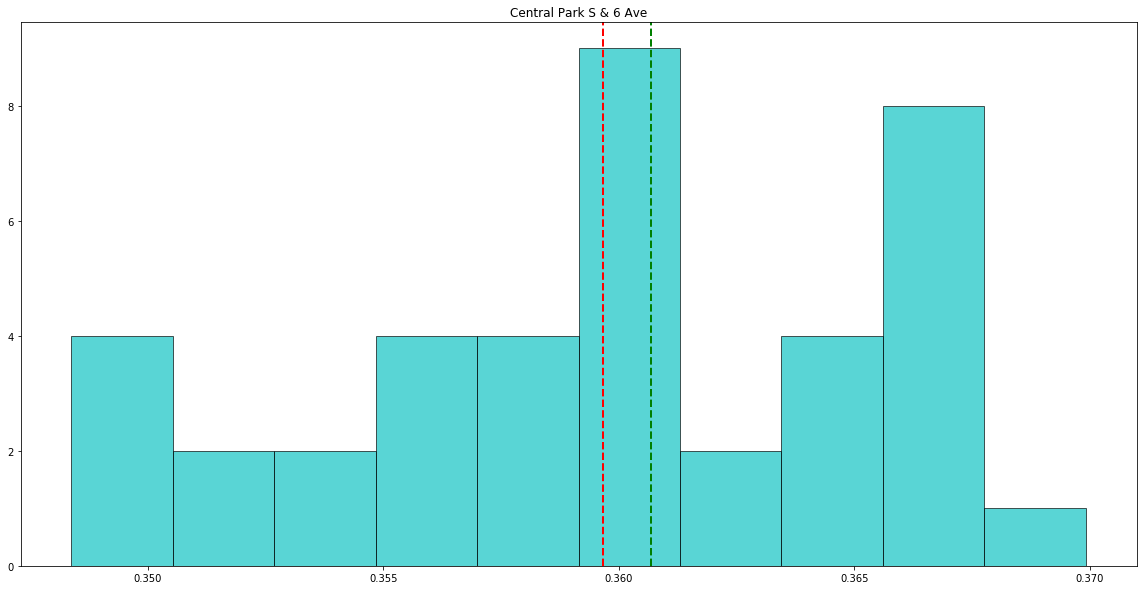

In [176]:
# assign random number so we can look at a variety of station distributions
wild = random.randrange(0, 39)

# get station name associated with this random column
station_name = correct.iloc[:,wild:wild+1].columns.to_list()[0]
# get the true distribution
correct_answer= correct.iloc[:,wild:wild+1].values.flatten()[0]

x = five.copy().iloc[:,wild:wild+1].values.flatten()
plt.figure(figsize=(20,10)) 
result = plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(correct_answer, color='g', linestyle='dashed', linewidth=2)
plt.title(station_name)
plt.show()


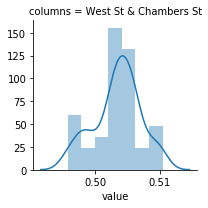

In [73]:
df = fifteen.copy().iloc[:,6:7]
dfm = df.melt(var_name='columns')
g = sns.FacetGrid(dfm, col='columns')
g = (g.map(sns.distplot, 'value'))

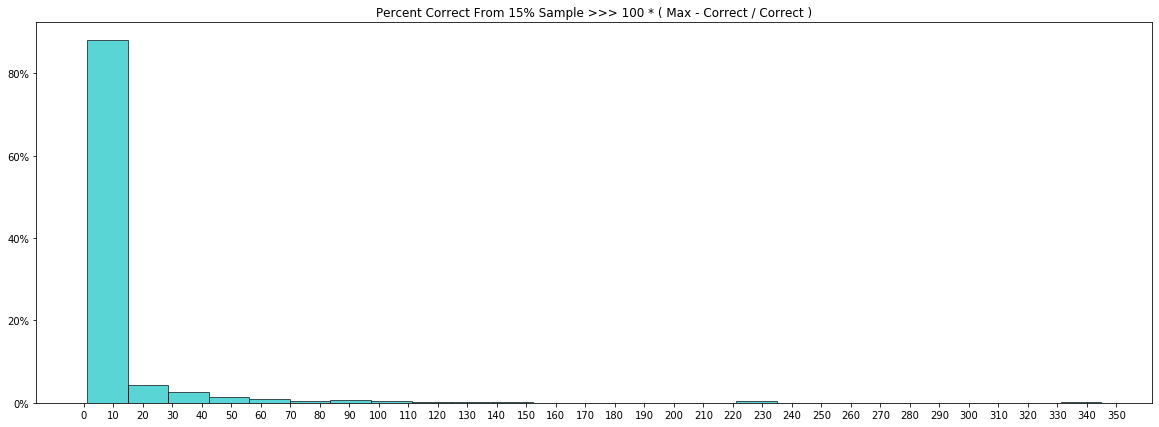

In [177]:

max_fifteen = fifteen.max().values.flatten()
min_fifteen = fifteen.min().values.flatten()
correct_values = correct.mean().values.flatten()
percent_off_max = 100 * ( (max_fifteen - correct_values) / correct_values)
weights = np.ones_like(correct_values) / len(correct_values)
plt.figure(figsize=(20,7)) 
result = plt.hist(percent_off_max, bins=25, color='c', edgecolor='k', alpha=0.65, weights=weights)
plt.xticks(np.arange(0, 360, 10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Percent Correct From 15% Sample >>> 100 * ( Max - Correct / Correct )')
plt.show()

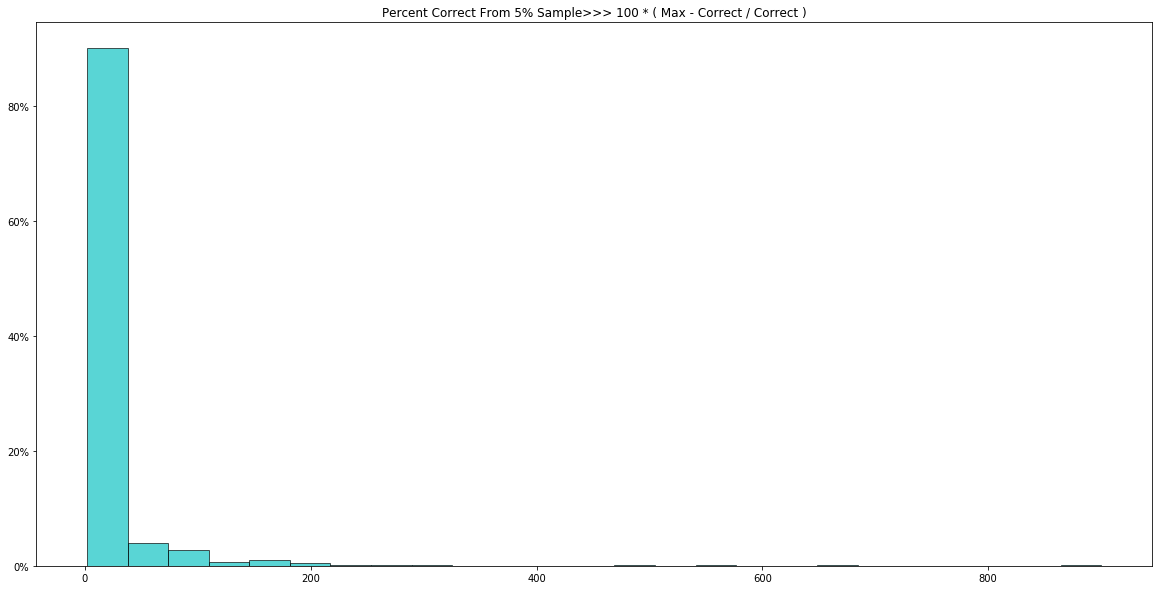

In [181]:

max_five = five.max().values.flatten()
min_five = five.min().values.flatten()
correct_values = correct.mean().values.flatten()
percent_off_max = 100 * ( (max_five - correct_values) / correct_values)
weights = np.ones_like(correct_values) / len(correct_values)
plt.figure(figsize=(20,10)) 
result = plt.hist(percent_off_max, bins=25, color='c', edgecolor='k', alpha=0.65, weights=weights)
# plt.xticks(np.arange(0, 360, 10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Percent Correct From 5% Sample>>> 100 * ( Max - Correct / Correct )')
plt.show()

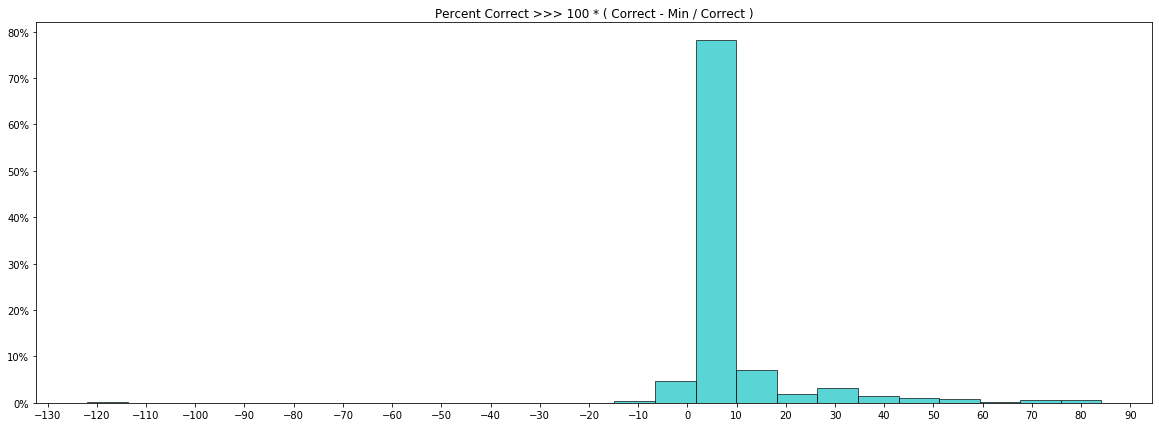

In [170]:
min_fifteen = fifteen.min().values.flatten()
correct_values = correct.mean().values.flatten()
percent_off_min = 100 * ( (correct_values - min_fifteen) / correct_values)
weights = np.ones_like(correct_values) / len(correct_values)
plt.figure(figsize=(20,7)) 
result = plt.hist(percent_off_min, bins=25, color='c', edgecolor='k', alpha=0.65, weights=weights)
plt.xticks(np.arange(-130, 100, 10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Percent Correct From 15% Sample >>> 100 * ( Correct - Min / Correct )')
plt.show()

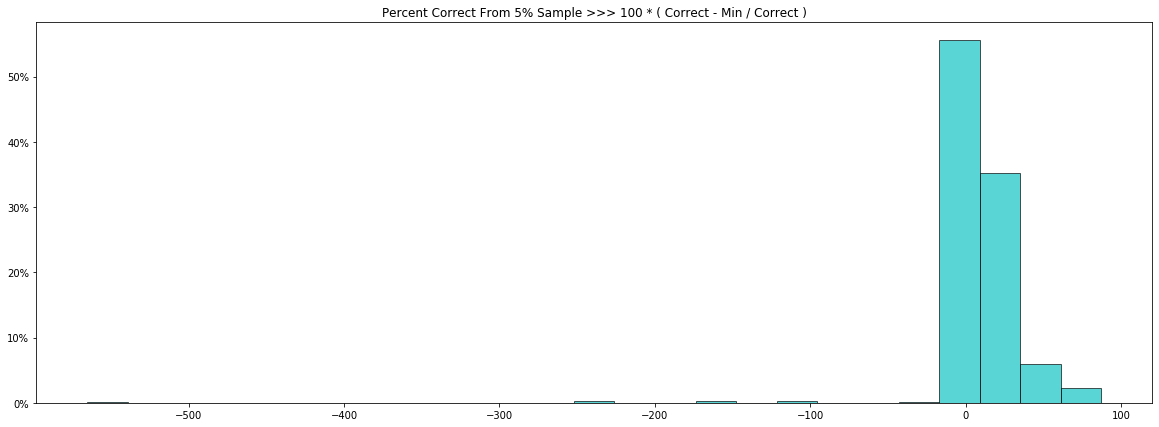

In [182]:
min_five = five.min().values.flatten()
correct_values = correct.mean().values.flatten()
percent_off_min = 100 * ( (correct_values - min_five) / correct_values)
weights = np.ones_like(correct_values) / len(correct_values)
plt.figure(figsize=(20,7)) 
result = plt.hist(percent_off_min, bins=25, color='c', edgecolor='k', alpha=0.65, weights=weights)
# plt.xticks(np.arange(-130, 100, 10))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Percent Correct From 5% Sample >>> 100 * ( Correct - Min / Correct )')
plt.show()

In [188]:
max_five = five.max().values.flatten()
min_five = five.min().values.flatten()
correct_values = correct.mean().values.flatten()
percent_off_max = 100 * ( (max_five - correct_values) / correct_values)
percent_off_min = 100 * ( (correct_values - min_five) / correct_values)

med_max_diff = round(np.median(percent_off_max),2)
med_min_diff = round(np.median(percent_off_min),2)

print(f'The median percent difference for the 5% sample is {med_max_diff} when using the max and {med_min_diff} when using the min.\n')

max_fifteen = fifteen.max().values.flatten()
min_fifteen = fifteen.min().values.flatten()
correct_values = correct.mean().values.flatten()
percent_off_max = 100 * ( (max_fifteen - correct_values) / correct_values)
percent_off_min = 100 * ( (correct_values - min_fifteen) / correct_values)

med_max_diff = round(np.median(percent_off_max),2)
med_min_diff = round(np.median(percent_off_min),2)

print(f'The median percent difference for the 5% sample is {med_max_diff} when using the max and {med_min_diff} when using the min.\n')

The median percent difference for the 5% sample is 8.4 when using the max and 8.17 when using the min.

The median percent difference for the 5% sample is 4.59 when using the max and 4.39 when using the min.



### Data Export Using 10% Subsample

In [212]:
# sql query to get 10% random sample
result = %sql SELECT * FROM yr_2020 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.1;
# convert into pandas df
yr_2020 = result.DataFrame()
# send to csv
yr_2020.to_csv('./rand_10/yr_2020.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [213]:
# sql query to get 10% random sample
result = %sql SELECT * FROM yr_2019 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.1;
# convert into pandas df
yr_2019 = result.DataFrame()
# send to csv
yr_2019.to_csv('./rand_10/yr_2019.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [214]:
# sql query to get 10% random sample
result = %sql SELECT * FROM yr_2018 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.1;
# convert into pandas df
yr_2018 = result.DataFrame()
# send to csv
yr_2018.to_csv('./rand_10/yr_2018.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [215]:
# sql query to get 10% random sample
result = %sql SELECT * FROM yr_2017 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.1;
# convert into pandas df
yr_2017 = result.DataFrame()
# send to csv
yr_2017.to_csv('./rand_10/yr_2017.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [216]:
# sql query to get 10% random sample
result = %sql SELECT * FROM yr_2016 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.1;
# convert into pandas df
yr_2016 = result.DataFrame()
# send to csv
yr_2016.to_csv('./rand_10/yr_2016.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [217]:
# sql query to get 10% random sample
result = %sql SELECT * FROM yr_2015 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.1;
# convert into pandas df
yr_2015 = result.DataFrame()
# send to csv
yr_2015.to_csv('./rand_10/yr_2015.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [218]:
# sql query to get 10% random sample
result = %sql SELECT * FROM yr_2014 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.1;
# convert into pandas df
yr_2014 = result.DataFrame()
# send to csv
yr_2014.to_csv('./rand_10/yr_2014.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [219]:
# sql query to get 10% random sample
result = %sql SELECT * FROM yr_2013 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.1;
# convert into pandas df
yr_2013 = result.DataFrame()
# send to csv
yr_2013.to_csv('./rand_10/yr_2013.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [220]:
# sql query to get 5% random sample
result = %sql SELECT * FROM yr_2020 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
# convert into pandas df
yr_2020 = result.DataFrame()
# send to csv
yr_2020.to_csv('./rand_5/yr_2020.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [221]:
# sql query to get 5% random sample
result = %sql SELECT * FROM yr_2019 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
# convert into pandas df
yr_2019 = result.DataFrame()
# send to csv
yr_2019.to_csv('./rand_5/yr_2019.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [222]:
# sql query to get 5% random sample
result = %sql SELECT * FROM yr_2018 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
# convert into pandas df
yr_2018 = result.DataFrame()
# send to csv
yr_2018.to_csv('./rand_5/yr_2018.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [223]:
# sql query to get 5% random sample
result = %sql SELECT * FROM yr_2017 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
# convert into pandas df
yr_2017 = result.DataFrame()
# send to csv
yr_2017.to_csv('./rand_5/yr_2017.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [224]:
# sql query to get 5% random sample
result = %sql SELECT * FROM yr_2016 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
# convert into pandas df
yr_2016 = result.DataFrame()
# send to csv
yr_2016.to_csv('./rand_5/yr_2016.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [225]:
# sql query to get 5% random sample
result = %sql SELECT * FROM yr_2015 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
# convert into pandas df
yr_2015 = result.DataFrame()
# send to csv
yr_2015.to_csv('./rand_5/yr_2015.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [226]:
# sql query to get 5% random sample
result = %sql SELECT * FROM yr_2014 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
# convert into pandas df
yr_2014 = result.DataFrame()
# send to csv
yr_2014.to_csv('./rand_5/yr_2014.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


In [227]:
# sql query to get 5% random sample
result = %sql SELECT * FROM yr_2013 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
# convert into pandas df
yr_2013 = result.DataFrame()
# send to csv
yr_2013.to_csv('./rand_5/yr_2013.csv', index=False)

 * sqlite:////Users/michaellink/Desktop/__NYCDSA/_Projects/Capstone/data/citibike/sqlite/citi_bike_year.db
Done.


#### Global - Total number of stations

In [ ]:
# get total number of distinct stations
result = %sql SELECT COUNT (DISTINCT start_station_name) FROM yr_2019;
num_station_global = result.DataFrame()
num_station_global.rename(columns={"COUNT (DISTINCT start_station_name)": "value"}, inplace=True)
num_station_global = num_station_global['value'].iloc[0]
num_station_global

#### Local - Total number of stations

In [ ]:
%%time
# get total number of distinct stations
# %sql SELECT COUNT (DISTINCT start_station_name) FROM yr_2019
result = %sql SELECT COUNT (DISTINCT start_station_name) FROM yr_2019 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;
    # can replace with pd dataframe later
num_station_local = result.DataFrame()
num_station_local.rename(columns={"COUNT (DISTINCT start_station_name)": "value"}, inplace=True)
num_station_local = num_station_local['value'].iloc[0]
num_station_local

#### Local - Experimentation to choose random sample method and to validate 5% grab

In [ ]:
%%time
# [55 seconds]
# Test on 5% grab of 2019 data with order by method
# https://stackoverflow.com/questions/4114940/select-random-rows-in-sqlite
result = %sql select * from yr_2019 order by random() limit 1048862;

In [ ]:
%%time
# [17 seconds]
# Test on 5% grab of 2019 data with abs method
# https://stackoverflow.com/questions/4114940/select-random-rows-in-sqlite
result = %sql SELECT * FROM yr_2019 WHERE abs(CAST(random() AS REAL))/9223372036854775808 < 0.05;

In [ ]:
%%time
# [5 seconds]
# Test on converting 5% grab of 2019 data into pandas dataframe
# This contributes little to the overall time
df_random_method_2 = result.DataFrame()
print(df_random_method_2.shape)
df_random_method_2.head(2)

In [ ]:
# Verifying that our grab was truly 5%

# Get total number of rows
result = %sql SELECT COUNT(*) FROM yr_2019;
num_observations = result.DataFrame()
num_observations.rename(columns={"COUNT(*)": "value"}, inplace=True)
num_observations = num_observations['value'].iloc[0]

# Get number of rows from random sample
num_row = df_random_method_2.shape[0]  

# Calculate percentage
percent = round(100 * ( num_row / num_observations), 2)
print(f'The randomly sampled dataset is {percent} percent of the original dataset')

In [ ]:
%%time
result = %sql SELECT * FROM yr_2020_test WHERE ID IN (SELECT ID FROM yr_2019 ORDER BY RANDOM() LIMIT 100)
# select * from yr_2019 where random() <= .01;
df_random = result.DataFrame()
df_random.head(2)

In [ ]:
result = %sql SELECT * from yr_2019 WHERE random()<200 / (SELECT COUNT(1) from logs)::float ORDER BY random() LIMIT 100;
# select * from yr_2019 where random() <= .01;
df_random = result.DataFrame()
df_random.head(2)

In [ ]:
%%time
# Order database randomly and take top %
result = %sql select * from yr_2019 where random() <= .01;
df_random = result.DataFrame()
df_random.head(2)

In [ ]:
%alias_magic t timeit

In [ ]:
# Approximately 20 seconds. Not a big problem if we run once and save as csv
results = %sql select * from yr_2019 order by random() limit 10;
df_random = result.DataFrame()
df_random.head(5)